In [1]:
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.linalg import cho_factor, cho_solve

from scripts.utils import listfiles
from subprocess import *

%matplotlib inline

## Elo

In [11]:
# implementando elo
# https://www.geeksforgeeks.org/elo-rating-algorithm/


def ELOProbability(rating1, rating2): 
    return 1.0 * 1.0 / (1 + 1.0 * math.pow(10, 1.0 * (rating1 - rating2) / 400)) 

def ELORating(Ra, Rb, d):

    K = 30

    Pb = ELOProbability(Ra, Rb)
    Pa = ELOProbability(Rb, Ra)

    # gana A
    if (d == 1) :
        Ra = Ra + K * (1 - Pa)
        Rb = Rb + K * (0 - Pb)
    # gana B
    else :
        Ra = Ra + K * (0 - Pa)
        Rb = Rb + K * (1 - Pb)

    return (round(Ra, 6), round(Rb, 6))

In [41]:
# generando dataframe para el ranking utilizando elo

table_names=['date', 'eq1', 'sc1', 'eq2', 'sc2']
atp_df = pd.read_table("../data/atp_matches_2015.dat", delimiter=' ', names=table_names)[1:]

atp_teams = pd.concat([atp_df.eq1, atp_df.eq2], axis=0).unique()
elo_rating = np.repeat(1500, len(atp_teams))

elo_df = pd.DataFrame(data={'id': atp_teams, 'elo': elo_rating})

for i, row in atp_df.iterrows():
    elo_eq1 = elo_df[elo_df.id==row.eq1].elo.iloc[0]
    elo_eq2 = elo_df[elo_df.id==row.eq2].elo.iloc[0]

    (elo_eq1, elo_eq2) = ELORating(elo_eq2, elo_eq1, row.sc1)

    elo_df.at[elo_df.id==row.eq1, "elo"] = elo_eq1
    elo_df.at[elo_df.id==row.eq2, "elo"] = elo_eq2

## Comparación

In [49]:
# generar csv para cmm y wp

!python metnum.py build;
!./tp ../data/atp_matches_2015.dat ../data/atp_matches_2015_CMM.out 0 ../data/atp_matches_2015_CMM.csv
!./tp ../data/atp_matches_2015.dat ../data/atp_matches_2015_WP.out 1 ../data/atp_matches_2015_WP.csv

resultados = pd.DataFrame()

cmm_df = pd.read_csv("../data/atp_matches_2015_CMM.csv").rename({'rating': 'CMM'}, axis=1)
resultados = cmm_df[['id', 'ganados', 'perdidos', 'jugados', 'CMM']].set_index("id")
wp_df = pd.read_csv("./prueba-wp.csv")[['id', 'rating']].rename({'rating': 'WP'}, axis=1)

resultados = resultados.join(wp_df.set_index("id"), on="id").join(elo_df.set_index("id"), on="id")
        
resultados

,ganados,perdidos,jugados,CMM,WP,elo
id,,,,,,
104527,55,19,74,1.036890,0.743243,1537.349815
103285,7,10,17,0.586419,0.411765,1475.268926
105147,8,12,20,0.532892,0.400000,1545.516582
106415,3,5,8,0.490583,0.375000,1557.218320
105572,7,11,18,0.582256,0.388889,1527.627736
...,...,...,...,...,...,...
127570,0,1,1,0.377427,0.000000,1472.823371
200537,1,0,1,0.625000,1.000000,1515.000000
118591,0,1,1,0.375000,0.000000,1485.000000


In [50]:
top_equipos = 30

top_cmm = cmm_df.sort_values(by='CMM', ascending=False).head(top_equipos)
top_wp = wp_df.sort_values(by='WP', ascending=False).head(top_equipos)
top_elo = elo_df.sort_values(by='elo', ascending=False).head(top_equipos)

In [53]:
resultados[['CMM','WP']]

,CMM,WP
id,,
104527,1.036890,0.743243
103285,0.586419,0.411765
105147,0.532892,0.400000
106415,0.490583,0.375000
105572,0.582256,0.388889
...,...,...
127570,0.377427,0.000000
200537,0.625000,1.000000
118591,0.375000,0.000000


<AxesSubplot:xlabel='CMM', ylabel='WP'>

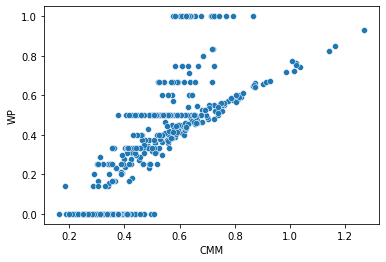

In [52]:
sns.scatterplot(x=resultados['CMM'], y=resultados['WP'])

In [56]:
resultados[['CMM', 'WP', 'elo']].corr()

,CMM,WP,elo
CMM,1.000000,0.805171,0.298047
WP,0.805171,1.000000,0.294345
elo,0.298047,0.294345,1.000000
